$\mathbf{Fast \ Fourier \ Transform}$ 

FFT transforms a signal from its time representation into the frequency domain by sampling data at fixed intervals and decomposing it into different frequencies. 

This algorithm recovers clusters by propagating waves through a graph. How does it use FFT on the local components. How does this work as a distributed system?


In [3]:
import numpy as np
from lib.spectral_clustering import similarity_matrix, laplacian_matrix, spectral_clustering
from lib.datasets import gaussian_mixture as gm
from lib.kmeans import kmeans
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
import scipy.fftpack
from lib.wave_clustering import wave_clustering
import scipy.signal
import gif

# Building Our Functions to Cluster with the Wave Equation

In [2]:
def array_to_binary(row):
    '''
    This function takes a row of 0's and 1's and turns it into binary, 
    backwards, so [0, 0, 1] becomes 4 
    '''
    binary_to_decimal = 0
    for i in range(len(row)):
        binary_to_decimal += row[i] * 2 ** i
    return binary_to_decimal

def cluster_wave_eq(k, T_max, num_nodes, c, normalized_laplacian):
    '''
    k = number of eigenvectors used, maybe??? < 2**k clusters
    T_max = number of iterations in time
    num_nodes = number of nodes in our graph
    c = constant in the wave equation. 0 < c < sqrt(2) for stability
    normalized_laplacian = D**{-1}L
    '''
    # initialize heat matrix: each row corresponds to a node, column corresponds to a step in time
    heat = np.zeros(shape = (num_nodes, T_max + 1)) #offset index by 1 because we need index -1, evolves with time
    #print(heat.shape)
    heat[:, 0] = np.random.uniform(size = num_nodes)
    heat[:, 1] = heat[:, 0] 
    #print(heat[:, 1].shape)
    # populate the heat matrix
    for i in range(2, T_max + 1): 
        heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
    # calculate FFT for each node, the nth entry corresponds to e^(2pi ni/N) and encodes amplitude and phase shift
    heat_fft = np.fft.fft(heat, axis=1)
    # Finds the index of the k largest power over each row
    indices = [sp.signal.find_peaks(heat_fft[j, :])[:k] for j in range(len(heat_fft))]
    eigenvector = np.zeros(shape = (num_nodes, k))
    binary = np.zeros(shape = (num_nodes, k))
    for i in range(num_nodes): # for each row, ie each node
        for j in range(k-1): # find the jth largest frequency
            eigenvector[i][j] = np.real(heat_fft[i][j])
            if eigenvector[i][j] > 0:
                binary[i][j] = 1
            else:
                binary[i][j] = 0
    cluster_num = [array_to_binary(binary[i]) for i in range(num_nodes)]
    return cluster_num


# Generating Data

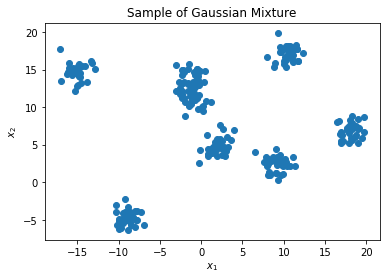

In [16]:
n_gaussians = 8
n_pts = 32
n = n_pts * n_gaussians
d = 2

data = gm(n_gaussians, n_pts, d, centroid_var=10)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Gaussian Mixture")
plt.show()

# Standard Graph Spectral Clustering

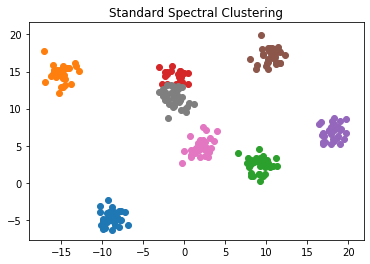

In [17]:
spectral = spectral_clustering(data, k=n_gaussians, lform="rw", metric = "g", s=1)
for i in range(len(spectral)):
    d = data[spectral == i].T
    x = d[0]
    y = d[1]
    plt.scatter(x,y)
plt.title("Standard Spectral Clustering")
plt.show()

# Wave Equation Clustering

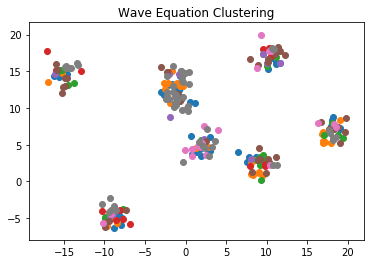

In [28]:
spectral = wave_clustering(data, k=8, T_max=10000, c=0.1, metric = "g", dynamics_gif_path="Dyanmics.gif")
for i in range(len(spectral)):
    d = data[spectral == i].T
    x = d[0]
    y = d[1]
    plt.scatter(x,y)
plt.title("Wave Equation Clustering")
plt.show()

# Line Graph Clustering

In [11]:
S = np.diag(np.ones(199), k=1) + np.diag(np.ones(199), k=-1)
S[100, 101] = 0.1
S[101, 100] = 0.1
L, deg = laplacian_matrix(S)
L_norm = (1/deg).reshape((-1, 1)) * L

k = 1
T_max = 1000
c = 1.41

In [12]:
n = len(L)

def dctmtx(n, normalize=False):
    d = sp.fftpack.dct(np.eye(n), axis=0)
    if(normalize):
        d = d / np.sqrt(np.sum(d**2, axis=1))
    return d

def find_extrema(vec):
    # a peak is a local min or local max
    # ie either greater than both neighbors, or less than both neighbors
    forward_diffs = vec[:-1] - vec[1:]
    backward_diffs = vec[1:] - vec[:-1]
    above_f_neighbor = np.concatenate(( (forward_diffs > 0), [False]) )
    above_b_neighbor = np.concatenate(( [False], backward_diffs > 0 ) )
    return np.where(np.logical_not(np.logical_xor(above_f_neighbor, above_b_neighbor)))[0]


Use fft and rfft on cosine waves to debug cos coefficient computations. Make sure peaks of the M matrix matches up, peaks should match. Be sure that fft identifies pure frequency components, eg exactly periodic.  Post process fourier coefficients and combine frequency bases to get cos sin basis. 

# Graph Laplacian Eigenfunctions for Line Graph

In [5]:
n = 500

line_graph_sim = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)
laplacian, diag = laplacian_matrix(line_graph_sim)
l_rw = (1/diag)[:, None] * laplacian

In [6]:
evals, evecs = sp.linalg.eigh(laplacian, np.diag(diag))

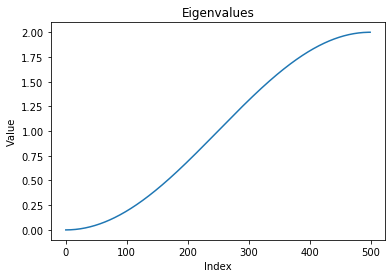

In [7]:
plt.plot(evals)
plt.title("Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

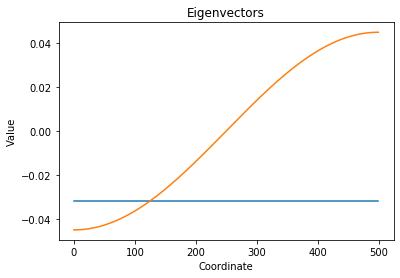

In [8]:
plt.plot(evecs[:, :2])
plt.title("Eigenvectors")
plt.xlabel("Coordinate")
plt.ylabel("Value")
plt.show()

Goal: do the eigenfunctions pop out of a time series on the graph? 

When we solve the heat equation using separation of variables, we are actually isolating dominant frequency components of a diffused signal. These dominant components don't involve time because of the separation of variables setup.

In [12]:
@gif.frame
def plot(i):
    plt.plot(evecs[:, :i])
    plt.title("Eigenvectors")
    plt.xlabel("Coordinate")
    plt.ylabel("Value")
frames = []
for i in range(2, 10):
    frames.append(plot(i))
gif.save(frames, 'example.gif', duration=50)

In [30]:
def wave_clustering(data_sim, k, T_max=1000, c=1.41, metric=None, kernel=None, dynamics_gif_path=None, **kwargs):
    '''
    Args:
        data (np.ndarray): (n,d) numpy array consisting of n d-valued points
        k (integer): desired number of clusters. Must be a power of 2.
        T_max: number of iterations of wave propagations to simulate. A larger value is slower but provides more accurate
            estimation of laplacian eigenvectors.
        c: wave propagation speed. 0 < c < sqrt(2) is required for guaranteed stability.
        metric: one of ["g", "e", "k"] - choose a metric for the data:
            "g" for Gaussian: d(x, y) = exp(-|x-y|^2 / 2 (s^2)). The scale `s` controls standard deviation.
            "e" for Exponential: d(x, y) = exp(-|x-y|/s). The scale `s` is the parameter of the exponential.
            "eps" for Epsilon neighbors: d(x, y) = |x-y| if less than epsilon, 0 otherwise
            "k" for Kernel: use an arbitrary kernel, given by the `kernel` argument.
        kernel: K(x, y, s) -> \R+ - an arbitrary distance function between two points of the same dimension with a given scale.
        dynamics_gif_path (str): if provided, save a gif at the given path showing the time evolution of the system
    Returns:
        A list of (n,) integers of the cluster assignments of each data point.
    '''
    k_ = int(np.log2(k))
    assert k_ == np.log2(k), "k must be a power of 2"

    #data_sim = similarity_matrix(data, metric=metric, kernel=kernel, **kwargs)
    n, _ = data_sim.shape
    laplacian, degree = laplacian_matrix(data_sim)
    rw_laplacian = (1/degree).reshape((-1, 1)) * laplacian

    wave = np.zeros((n, T_max + 1))

    wave[:, 0] = np.random.uniform(size=n)
    wave[:, 1] = wave[:, 0]
    
    frames = []
    
    @gif.frame
    def plot(i):
        plt.plot(wave[:, i])
        plt.xlabel("Graph Node")
        plt.ylabel("Function Value")
        plt.ylim((np.min(wave), np.max(wave)))
                 
    for i in range(2, T_max + 1):
        wave[:, i] = 2 * wave[:, i-1] - wave[:, i-2] - (c**2) * (rw_laplacian @ wave[:, i-1])
    
    if(dynamics_gif_path is not None):  
        for i in range(2, T_max + 1, 50):
            frames.append(plot(i))
        gif.save(frames, dynamics_gif_path, duration=50)

    wave_fft = np.fft.rfft(wave[:, 1:], axis=1)
    wave_cos_coeffs = cos_coeffs(wave_fft)

    freq_peaks = [scipy.signal.find_peaks(np.abs(wave_cos_coeffs[idx, 1:]))[0] for idx in range(n)]
    truncated_freq_peaks = np.stack([f[:k_] for f in freq_peaks])

    cluster_assns = np.zeros((n,))
    for i in range(n):
        for j, freq_peak in enumerate(truncated_freq_peaks[i]):
            if wave_cos_coeffs[i][freq_peak] > 0:
                cluster_assns[i] += 2**j
    return cluster_assns


def gimme_cos(n, k):
    '''
    Return a length n column vector whose components are cosine waves of frequency k/(n-1)
    '''
    return np.cos(2 * np.pi * k * np.arange(n) / n)

def gimme_sin(n, k):
    '''
    Return a length n column vector whose components are cosine waves of frequency k/(n-1)
    '''
    return np.sin(2 * np.pi * k * np.arange(n) / n)

def cos_coeffs(fourier_coeffs):
    '''
    Given a sequence of two-sided fourier coefficients (negative freqs, positive freqs) return the corresponding two-sided cos coeffs
    '''
    return np.real(fourier_coeffs)

def sin_coeffs(fourier_coeffs):
    '''
    Given a sequence of two-sided fourier coefficients (negative freqs, positive freqs) return the corresponding two-sided sin coeffs
    '''
    return -np.imag(fourier_coeffs)

In [31]:
wave_similarity_graph = np.diag(np.ones(49), k=-1) + np.diag(np.ones(49), k=1)
wave_similarity_graph[25, 26] = 0.01
wave_similarity_graph[26, 25] = 0.01


In [33]:
spectral = wave_clustering(wave_similarity_graph, k=8, T_max=10000, c=0.1, metric = "g", dynamics_gif_path="Dyanmics.gif")
